In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d shreyasparaj1/lung-cancer-dataset
!unzip -q lung-cancer-dataset.zip -d dataset

  0% 0.00/2.00k [00:00<?, ?B/s]
100% 2.00k/2.00k [00:00<00:00, 5.13MB/s]


In [4]:
df = pd.read_csv('/content/dataset/Lung_Cancer_Dataset.csv')

df['LUNG_CANCER'] = df['LUNG_CANCER'].apply(lambda x: 1 if x == 'YES' else 0)
df['GENDER'] = df['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
# Display the first few rows of the dataset
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('LUNG_CANCER', axis=1)  # Features
y = df['LUNG_CANCER'] # Target variable

# First split: Separate out the training set (75% of the dataset)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

# Second split: Divide the temporary set into validation and test sets
# Adjusting test_size here to get 15% of the original dataset for the test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

# - Training set: X_train, y_train (75% of the dataset)
# - Validation set: X_val, y_val (10% of the dataset)
# - Test set: X_test, y_test (15% of the dataset)

# Optionally, print the sizes of each set to confirm
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 231
Validation set size: 31
Test set size: 47


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np

def evaluate_model(model, model_name, X_test, y_test):
    # Ensure y_test is binary to plot ROC
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted   NO', 'Predicted YES'],
                yticklabels=['Actual NO', 'Actual YES'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Calculating Metrics
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)  # Recall
    specificity = recall_score(y_test, y_pred, pos_label=0)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Displaying Metrics
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-score: {f1:.4f}\n")

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Evaluate the basic model on the validation set
val_predictions = dt.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy of basic model: {val_accuracy:.4f}")

# Define the parameter grid to search over
param_grid = {
    'max_depth': [None, 2, 3, 4, 5, 10],
    'min_samples_split': [2, 4, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit it to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the optimized model on the validation set
best_dt = grid_search.best_estimator_

# Predictions on the training set
dt_train_predictions = best_dt.predict(X_train)
dt_train_accuracy = accuracy_score(y_train, dt_train_predictions)

# Predictions on the validation set
dt_val_predictions = best_dt.predict(X_val)
dt_val_accuracy = accuracy_score(y_val, dt_val_predictions)

# Predictions on the test set
dt_test_predictions = best_dt.predict(X_test)
dt_test_accuracy = accuracy_score(y_test, dt_test_predictions)

# Display the accuracies
print(f"Training Accuracy: {dt_train_accuracy:.4f}")
print(f"Validation Accuracy: {dt_val_accuracy:.4f}")
print(f"Test Accuracy: {dt_test_accuracy:.4f}")

Validation Accuracy of basic model: 0.9677
Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation accuracy: 0.8483
Training Accuracy: 0.9481
Validation Accuracy: 0.9032
Test Accuracy: 0.9574


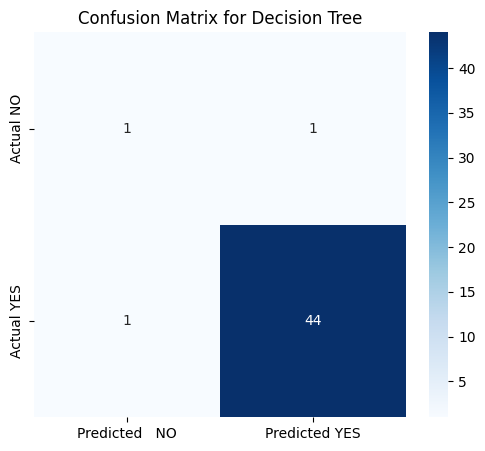

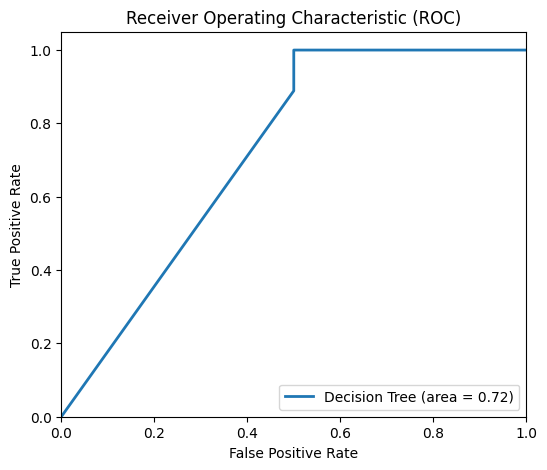

Metrics for Decision Tree:
Accuracy: 0.9574
Sensitivity (Recall): 0.9778
Specificity: 0.5000
Precision: 0.9778
F1-score: 0.9778



In [ ]:
# Evaluate Decision Tree Model
evaluate_model(best_dt, 'Decision Tree', X_test, y_test)

# SVM

In [ ]:
from sklearn.svm import SVC

svm_linear = SVC(kernel='linear', probability=True, random_state=42).fit(X_train, y_train)
svm_linear_y_train_pred = svm_linear.predict(X_train)
svm_linear_train_accuracy = accuracy_score(y_train, svm_linear_y_train_pred)
svm_linear_y_val_pred = svm_linear.predict(X_val)
svm_linear_val_accuracy = accuracy_score(y_val, svm_linear_y_val_pred)
svm_linear_y_test_pred = svm_linear.predict(X_test)
svm_linear_test_accuracy = accuracy_score(y_test, svm_linear_y_test_pred)

svm_poly = SVC(kernel='poly', probability=True, random_state=42).fit(X_train, y_train)
svm_poly_y_train_pred = svm_poly.predict(X_train)
svm_poly_train_accuracy = accuracy_score(y_train, svm_poly_y_train_pred)
svm_poly_y_val_pred = svm_poly.predict(X_val)
svm_poly_val_accuracy = accuracy_score(y_val, svm_poly_y_val_pred)
svm_poly_y_test_pred = svm_poly.predict(X_test)
svm_poly_test_accuracy = accuracy_score(y_test, svm_poly_y_test_pred)

svm_rbf = SVC(kernel='rbf', probability=True, random_state=42).fit(X_train, y_train)
svm_rbf_y_train_pred = svm_rbf.predict(X_train)
svm_rbf_train_accuracy = accuracy_score(y_train, svm_rbf_y_train_pred)
svm_rbf_y_val_pred = svm_rbf.predict(X_val)
svm_rbf_val_accuracy = accuracy_score(y_val, svm_rbf_y_val_pred)
svm_rbf_y_test_pred = svm_rbf.predict(X_test)
svm_rbf_test_accuracy = accuracy_score(y_test, svm_rbf_y_test_pred)

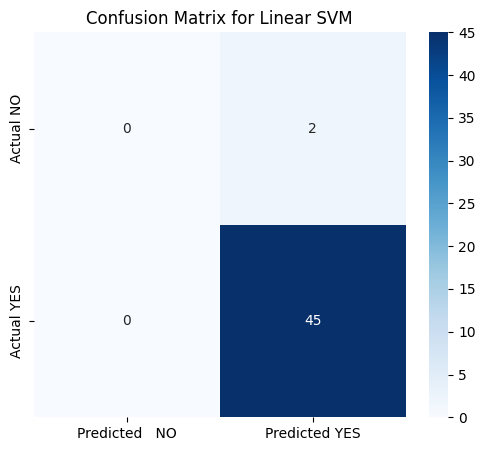

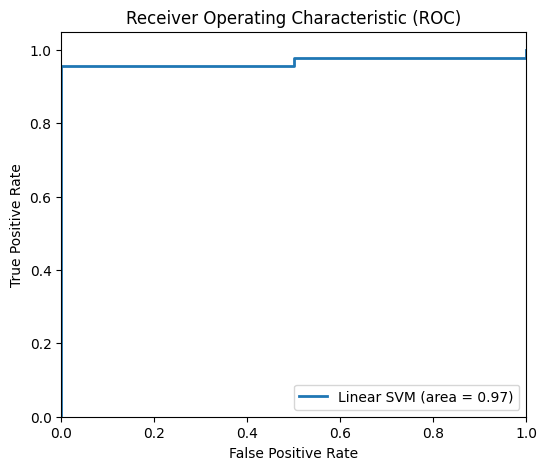

Metrics for Linear SVM:
Accuracy: 0.9574
Sensitivity (Recall): 1.0000
Specificity: 0.0000
Precision: 0.9574
F1-score: 0.9783



In [ ]:
evaluate_model(svm_linear, "Linear SVM", X_test, y_test)

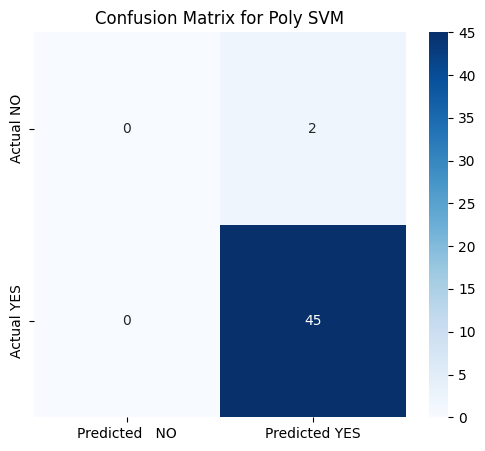

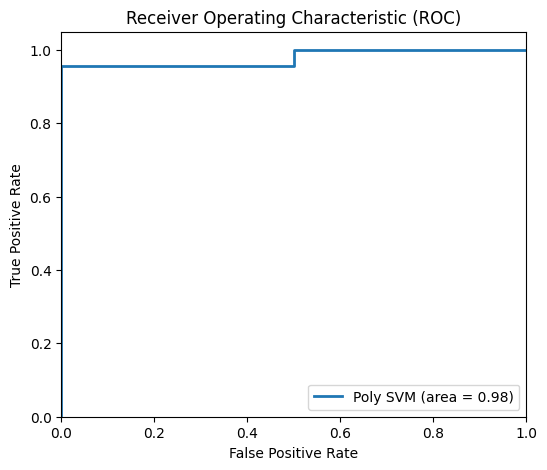

Metrics for Poly SVM:
Accuracy: 0.9574
Sensitivity (Recall): 1.0000
Specificity: 0.0000
Precision: 0.9574
F1-score: 0.9783



In [ ]:
evaluate_model(svm_poly, "Poly SVM", X_test, y_test)

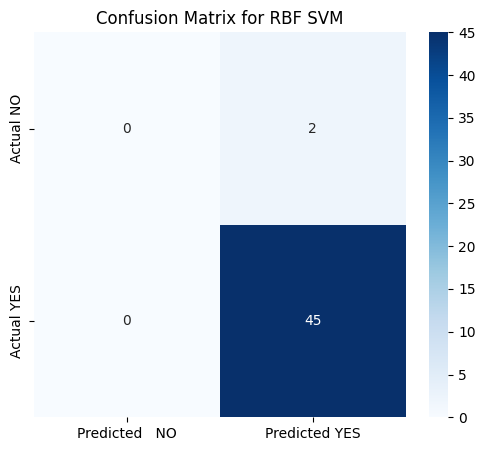

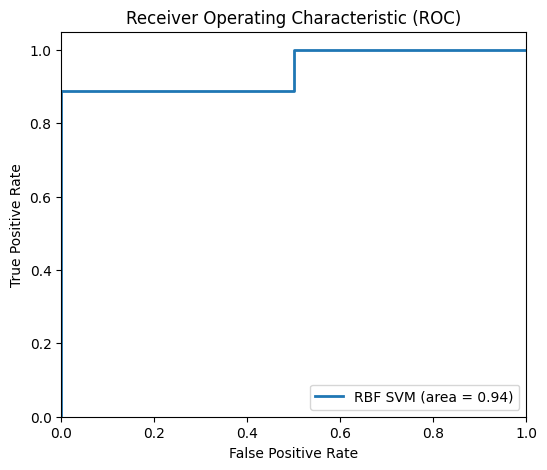

Metrics for RBF SVM:
Accuracy: 0.9574
Sensitivity (Recall): 1.0000
Specificity: 0.0000
Precision: 0.9574
F1-score: 0.9783



In [ ]:
evaluate_model(svm_rbf, "RBF SVM", X_test, y_test)

# Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000).fit(X_train, y_train)

# Accuracy on train data
lr_y_train_pred = lr.predict(X_train)
lr_train_accuracy = accuracy_score(y_train, lr_y_train_pred)

# Accuracy on validation data
lr_y_val_pred = lr.predict(X_val)
lr_val_accuracy = accuracy_score(y_val, lr_y_val_pred)

# Accuracy on test data
lr_y_test_pred = lr.predict(X_test)
lr_test_accuracy = accuracy_score(y_test, lr_y_test_pred)

# Display the accuracies
print(f"Training Accuracy: {lr_train_accuracy:.4f}")
print(f"Validation Accuracy: {lr_val_accuracy:.4f}")
print(f"Test Accuracy: {lr_test_accuracy:.4f}")

Training Accuracy: 0.9264
Validation Accuracy: 0.9677
Test Accuracy: 0.9574


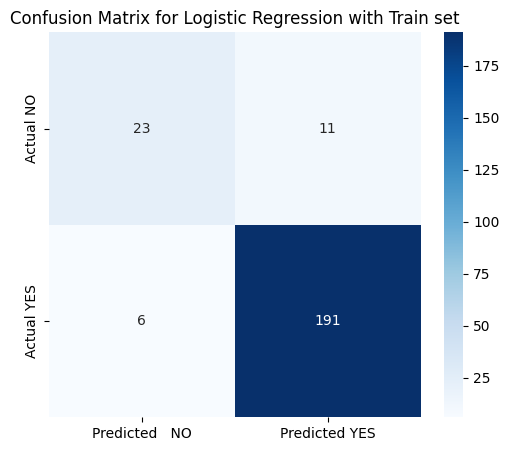

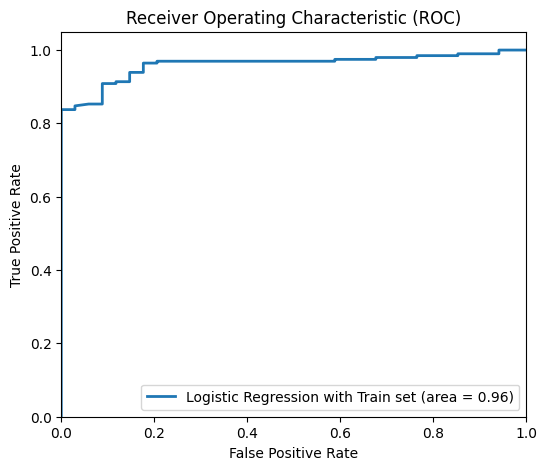

Metrics for Logistic Regression with Train set:
Accuracy: 0.9264
Sensitivity (Recall): 0.9695
Specificity: 0.6765
Precision: 0.9455
F1-score: 0.9574



In [9]:
# Evaluate the Logistic Regression model with train data
evaluate_model(lr, 'Logistic Regression with Train set', X_train, y_train)

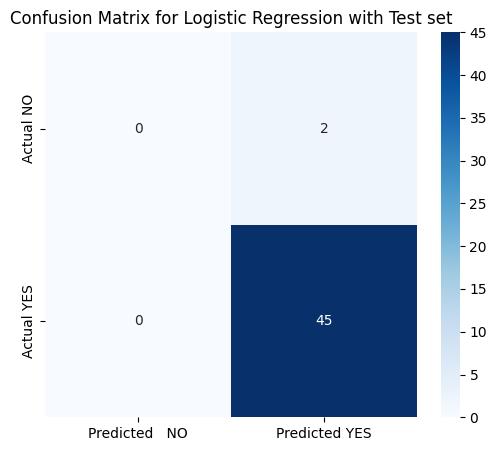

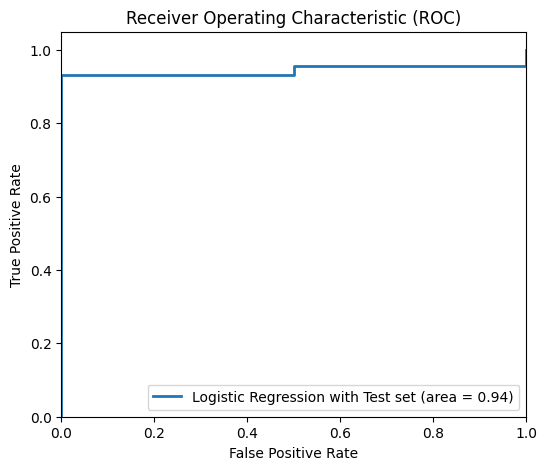

Metrics for Logistic Regression with Test set:
Accuracy: 0.9574
Sensitivity (Recall): 1.0000
Specificity: 0.0000
Precision: 0.9574
F1-score: 0.9783



In [10]:
# Evaluate the Logistic Regression model with test data
evaluate_model(lr, 'Logistic Regression with Test set', X_test, y_test)

# KNN

In [ ]:
def model_scores(X,y,model):
  y_pred = model.predict(X)
  # Calculate the confusion matrix
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  # Calculate the testing accuracy, sensitivity, and specificity
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  sensitivity = tp / (tp + fn)
  specificity = tn / (tn + fp)
  return accuracy, sensitivity, specificity

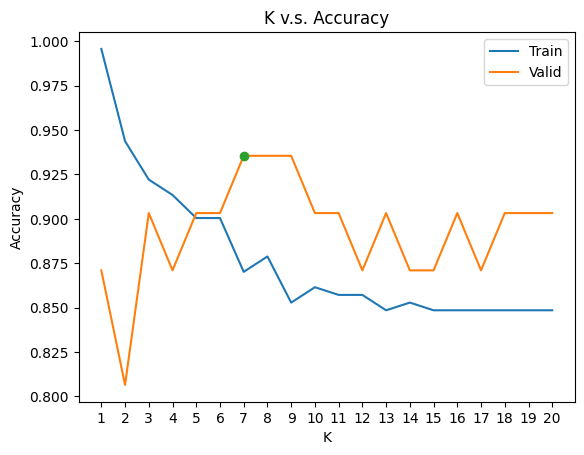

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
ks=range(1,21)
train_accs = []
valid_accs = []

for k in ks:
  knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
  train_scores = model_scores(X_train, y_train,knn)
  valid_scores = model_scores(X_val,y_val,knn)
  train_accs.append(train_scores[0])
  valid_accs.append(valid_scores[0])

best_valid = max(valid_accs)
best_k = valid_accs.index(best_valid) + 1

plt.plot(ks, train_accs, label='Train')
plt.plot(ks, valid_accs, label='Valid')
plt.plot(best_k, best_valid, marker='o')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.xticks(range(1,21))
plt.legend()
plt.title("K v.s. Accuracy")
plt.show()

In [ ]:
best_k

7

In [ ]:
## Scores on best k, best k is 7
knn_best = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)
print('Train accuracy with k = %d: %.4f' % (best_k, model_scores(X_train,y_train, knn_best)[0]))
print('Valid accuracy with k = %d: %.4f' % (best_k, model_scores(X_val,y_val, knn_best)[0]))
print('Test accuracy with k = %d: %.4f' % (best_k, model_scores(X_test, y_test, knn_best)[0]))

Train accuracy with k = 7: 0.8701
Valid accuracy with k = 7: 0.9355
Test accuracy with k = 7: 0.9574


In [ ]:
knn_train_accuracy = 0.8701
knn_val_accuracy = 0.9355
knn_test_accuracy = 0.9574

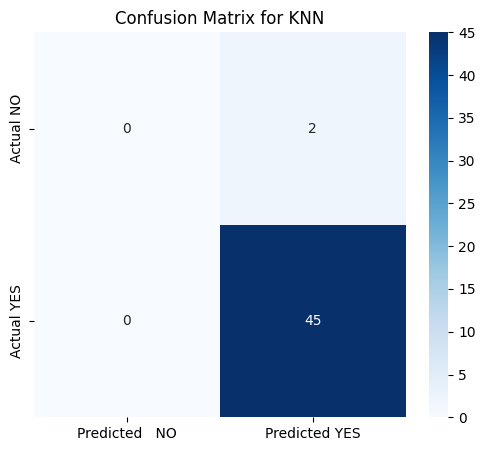

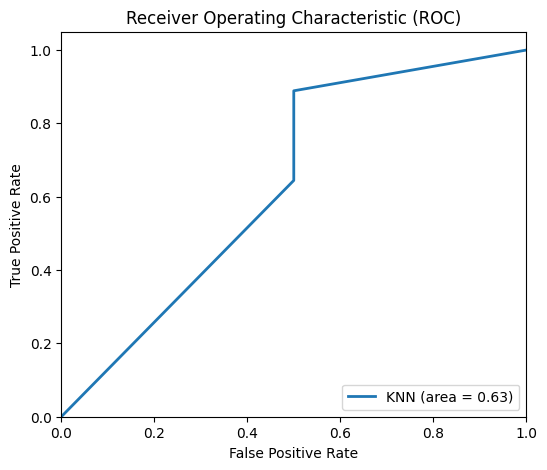

Metrics for KNN:
Accuracy: 0.9574
Sensitivity (Recall): 1.0000
Specificity: 0.0000
Precision: 0.9574
F1-score: 0.9783



In [ ]:
evaluate_model(knn_best, "KNN", X_test, y_test)

# Plot accuracy rates

In [ ]:
labels = ["Decision Tree", "SVM_linear", "SVM_poly", "SVM_rbf", "Logistic Regression", "KNN"]

Train accuracy plot

Text(0, 0.5, 'Accuracy')

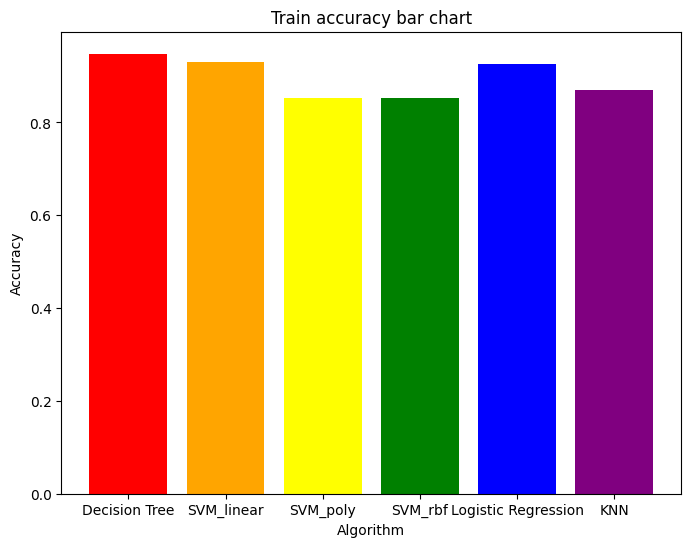

In [ ]:
train_accuracies = [dt_train_accuracy, svm_linear_train_accuracy, svm_poly_train_accuracy, svm_rbf_train_accuracy, lr_train_accuracy, knn_train_accuracy]
plt.figure(figsize=(8, 6))
plt.bar(labels, train_accuracies, color=['red', 'orange', 'yellow', 'green', 'blue', 'purple'])
plt.title('Train accuracy bar chart')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')

Validation accuracy plot

Text(0, 0.5, 'Accuracy')

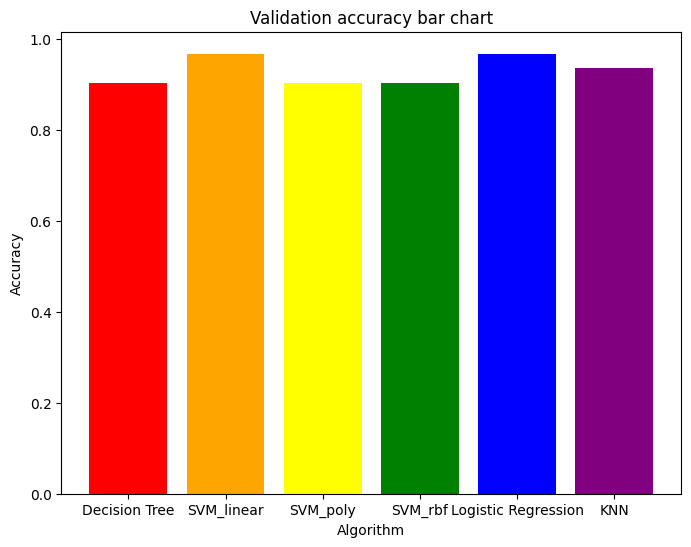

In [ ]:
val_accuracies = [dt_val_accuracy, svm_linear_val_accuracy, svm_poly_val_accuracy, svm_rbf_val_accuracy, lr_val_accuracy, knn_val_accuracy]
plt.figure(figsize=(8, 6))
plt.bar(labels, val_accuracies, color=['red', 'orange', 'yellow', 'green', 'blue', 'purple'])
plt.title('Validation accuracy bar chart')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')

Test accuracy plot

Text(0, 0.5, 'Accuracy')

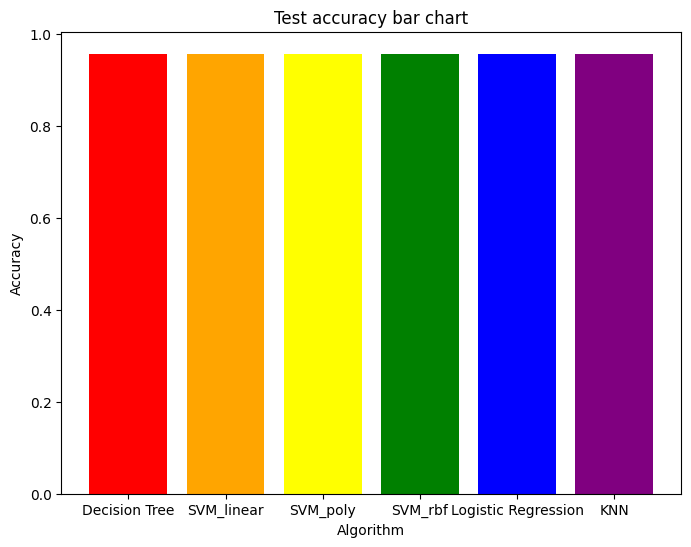

In [ ]:
test_accuracies = [dt_test_accuracy, svm_linear_test_accuracy, svm_poly_test_accuracy, svm_rbf_test_accuracy, lr_test_accuracy, knn_test_accuracy]
plt.figure(figsize=(8, 6))
plt.bar(labels, test_accuracies, color=['red', 'orange', 'yellow', 'green', 'blue', 'purple'])
plt.title('Test accuracy bar chart')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')

Line plot

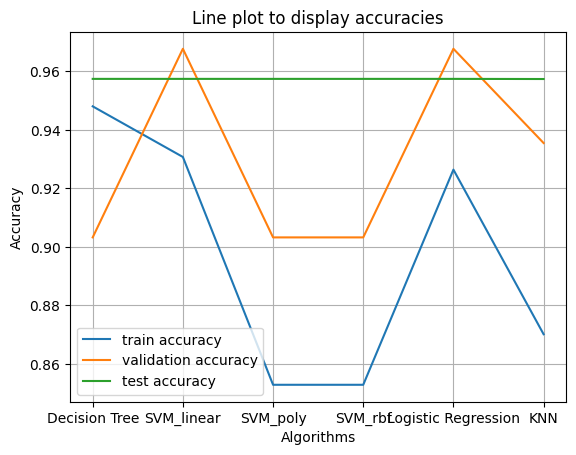

In [ ]:
plt.plot(labels, train_accuracies, label='train accuracy')
plt.plot(labels, val_accuracies, label='validation accuracy')
plt.plot(labels, test_accuracies, label='test accuracy')
plt.title ('Line plot to display accuracies')
plt.xlabel ('Algorithms')
plt.ylabel ('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# Define a function to extract the top 3 important features using permutation importance
def get_top_3_features(X, y, model, feature_names=df.columns):
  result = permutation_importance(model, X, y, random_state=1513)
  feature_importances = result.importances_mean
  top_3_idx = feature_importances.argsort()[::-1][:3]
  top_3_features = feature_names[top_3_idx]
  return top_3_features
# Extract the top 3 important features for each classifier
lr_top_3 = get_top_3_features(X_train, y_train, lr)
knn_top_3 = get_top_3_features(X_train, y_train, knn_best)
svm_top_3 = get_top_3_features(X_train, y_train, svm_rbf)
dt_top_3 = get_top_3_features(X_train, y_train, best_dt)
# Print out the top 3 important features for each classifier
print("Top 3 important features for logistic regression classifier:", ', '.join(lr_top_3))
print("Top 3 important features for k-NN classifier:", ', '.join(knn_top_3))
print("Top 3 important features for SVM classifier:", ', '.join(svm_top_3))
print("Top 3 important features for decision tree classifier:", ', '.join(dt_top_3))

Top 3 important features for logistic regression classifier: ALCOHOL CONSUMING, ALLERGY , SWALLOWING DIFFICULTY
Top 3 important features for k-NN classifier: ALLERGY , SWALLOWING DIFFICULTY, COUGHING
Top 3 important features for SVM classifier: CHEST PAIN, SWALLOWING DIFFICULTY, SHORTNESS OF BREATH
Top 3 important features for decision tree classifier: ALLERGY , ALCOHOL CONSUMING, SWALLOWING DIFFICULTY
